<h2><center>ECE 594N: Homework 4 Group Project</center></h2>
<h1><center>Human Pose Classifcation Using Manifold Learning</center></h1>
<h3><center>by Abhijith Atreya, Jax Burd, and Christos Zangos</center></h3>
    
---------------------------------------------------------------------------------------------------------------------------

# Project Goal

To distinguish between certain actions using 2D full body-based keypoints pulled from an open dataset. We first performed 2 PCA methods to extract a minimum number of components to represent our data. Both of which we apply logistic regression and compare classifcation accuracies for various number of components chosen.

![](images/human_poses.JPG)


# MPII Human Pose Dataset
- <b>Dataset available at:</b> <http://human-pose.mpi-inf.mpg.de/>


- <b>Citation:</b> <em>Mykhaylo Andriluka and Leonid Pishchulin and Peter Gehler and Schiele, Bernt. 2D Human Pose Estimation: New Benchmark and State of the Art Analysis. IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Jun 2014</em>

Created as a new benchmark for 2D human pose estimation in 2014, MPII Human pose features about 25K images total, and over 40K people with annotated body joints. The images and their annotations depict 410 different human activities. Some examples are (but not limited to) dancing, running, playing a musical intrument, meditating, etc.

![](images/human_pose_activities.PNG)

All images were extracted from YouTube, and was the result of a collaboration from researches at the Max Planck Institute for Intelligent Systems in Germany and Stanford University in the United States.

### Keypoint Labels
The dataset annotated all the joints on their images with the 16 total features listed below, each containing a x and y position coordinate. The dataset also tells us whether or not the joint is visible, as some images don't show the who human body or people are angled in such a way that a keypoint is hidden.

![](images/skeleton_diagram.PNG)


### Standing and Eating
In our project we wanted to focus on two activities within the dataset that would be reasonable to distinguish based off their keypoint skeletons. For this reason we decided to attempt classifying between the activities of <b>standing</b> and <b>eating</b>, as it was assumed their poses are distinct enough to yeild good results.


![](images/all_poses.JPG)

### Implementation
Extracting the keypoints into the codebase

In [2]:
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio
import pandas as pd
import numpy as np
from utils import *
from sklearn.model_selection import train_test_split
from geomstats.geometry.euclidean import EuclideanMetric

INFO: Using numpy backend


In [ ]:
# Load the MPII dataset
mat = sio.loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat', struct_as_record=False)

In [ ]:

rel = mat['RELEASE']

obj_rel = rel[0,0]

annolist = obj_rel.__dict__['annolist']
img_tra = obj_rel.__dict__['img_train']
act = obj_rel.__dict__['act']

n = annolist.shape[1]

In [1]:
# All the columns of the data 

data_arr = ['NAME','r ankle_X','r ankle_Y', 'r knee_X','r knee_Y', 'r hip_X','r hip_Y', 'l hip_X','l hip_Y', 'l knee_X','l knee_Y', 'l ankle_X','l ankle_Y','pelvis_X','pelvis_Y','thorax_X','thorax_Y','upper neck_X','upper neck_Y', 'head top_X','head top_Y', 'r wrist_X','r wrist_Y','r elbow_X','r elbow_Y', 'r shoulder_X','r shoulder_Y','l shoulder_X','l shoulder_Y','l elbow_X','l elbow_Y', 'l wrist_X','l wrist_Y','Scale','Activity','Category']

data = pd.DataFrame(columns=data_arr)

Convert_data_to_CSV(annolist, act, data_arr, img_tra)

In [5]:
# Load the CSV
df_obj = pd.read_csv('mpii_dataset.csv')
input_running_filtered, input_cycling_filtered ,  input_standing , input_eating = Clean_data(df_obj,data_arr)


input1 = input_running_filtered 
input2 = input_cycling_filtered
# Comment these lines to get results for running vs bicylcing
input1 = input_standing 
input2 = input_eating

070859331.jpg
(1280, 720)


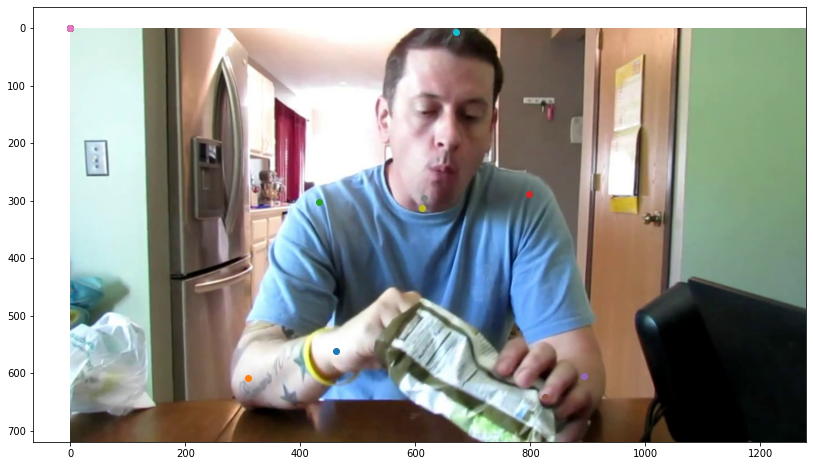

In [37]:
# Display an image with keypoints
# "image_id" is used to index an image from the dataframe
image_id = 4
imag(input2,input2.index[image_id])

In [7]:
# Generate dataset and labels 

ip1, ip1_labels=format_dataframe(input1,0)
ip2, ip2_labels=format_dataframe(input2,1)

dataset=np.concatenate((ip1,ip2))
labels=np.concatenate((ip1_labels,ip2_labels))
dataset[np.isnan(dataset).any(axis=2)] = 0

### Principle Component Analysis
- Principle componenet analysis (PCA) is a linear dimensionality reduction technique.
- PCA extracts features from the input space and projects it to a lower dimensional sub space.
- The main objective of PCA is to find a optimal projection matrix 
$$
\mathbf{X} \in \mathbb{R}^{n \times d}\rightarrow 
\mathbf{U} \in \mathbb{R}^{n \times r} 
 
 $$
 

- On Euclidean Space this can be achieved through the PCA function in `sklearn` package

- On a manifold, we use the `geomstats` package which projects the data on the manifold to a tangent space.
We then perform, PCA using the euclidian metric on the tangent space

Let's perform PCA using the Euclidian distance metric:

Text(0.5, 1.0, 'Explained variance for Euclidian space')

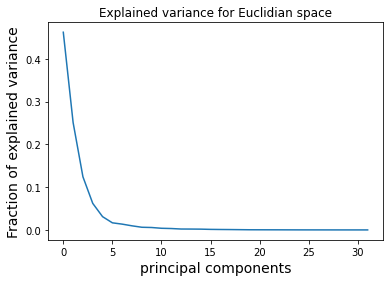

In [9]:
# PCA
import warnings
warnings.filterwarnings("ignore")
train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 32
for i in range(10):
    X_train_pca, y_train,train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("principal components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.title("Explained variance for Euclidian space")

The explained variance represents the fraction of information obtained using each principle component. 
- From the above graph, we observe that, there is negligible amount of information gained after 5 principle components for our data
- This means that the most of input data containing 32 features can be explained by using just 5 features

Now, we can observe the how the datapoints lie on the first 3 principle components:

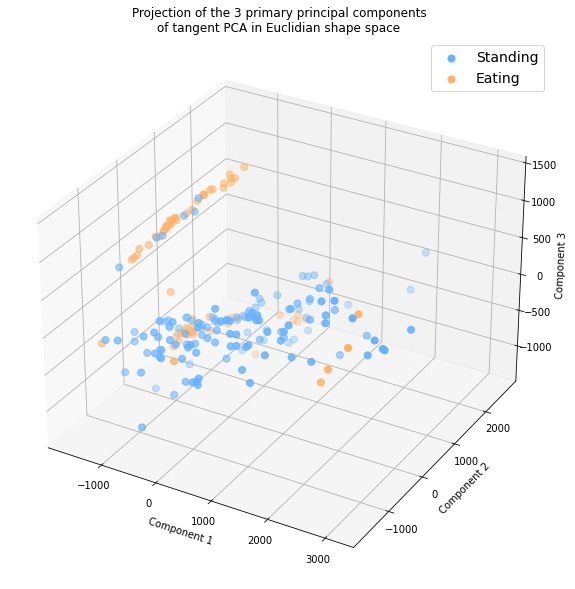

In [22]:
# Projection of First X Pricinple Tangent Components
label_to_str = {0: "Standing", 1: "Eating"}
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}
pca_handle = PCA(n_components =32)
nsamples, nx, ny = dataset.shape
data_reshaped = dataset.reshape((nsamples,nx*ny))
dataset_pca = pca_handle.fit_transform(data_reshaped)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

for label, col in label_to_color.items():
    mask = labels == label
    ax.scatter(dataset_pca[mask, 0], dataset_pca[mask, 1],dataset_pca[mask, 2], color=col, s=50, label=label_to_str[label])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
plt.legend(fontsize=14)
plt.title(
    "Projection of the 3 primary principal components"
    "\nof tangent PCA in Euclidian shape space"
);

### PCA on Kendall Shape Space

To performing PCA on manifolds, we first project all the points on the manifold to a tangent space.
For the points projected in the tangent space, we perform priciple component analysis.


![](images/kendall.JPG)


Text(0.5, 1.0, 'Explained variance for Kendall shape space')

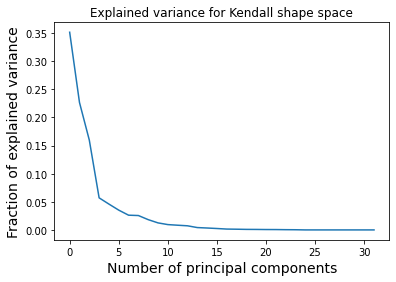

In [11]:
# Tangent PCA
# Perform classification on tangent space

train_acc_avg = list()
test_acc_avg = list()
n_components = 32
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, n_components)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

plt.figure()
plt.plot(t_pca.explained_variance_ratio_)
plt.xlabel("Number of principal components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.title("Explained variance for Kendall shape space")

The above plot shows the explained variance in the Kendall shape space.
We observe that, in the Kendall space more number of principle components are required to represent our data.

Now, let's plot the first 3 principle components of the data:

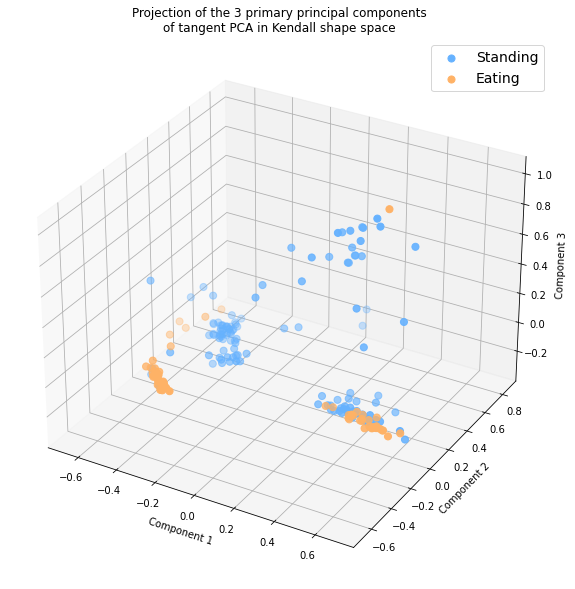

In [23]:
# Projection of First X Pricinple Tangent Components

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

for label, col in label_to_color.items():
    mask = labels == label
    ax.scatter(X[mask, 0], X[mask, 1],X[mask, 2], color=col, s=50, label=label_to_str[label])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
plt.legend(fontsize=14)
plt.title(
    "Projection of the 3 primary principal components"
    "\nof tangent PCA in Kendall shape space"
);

### Evaluating the distance matrix
- The distance matrix shows the pairwise distance from each point to all the other points in the dataset.
- The color of each cell represents how far the 2 points are in the D-dimensions.
- We plot the distance matrix using Euclidian distance and Kendall metric and compare them below

Text(0.5, 1.0, 'Distance matrix for Kendall shape space')

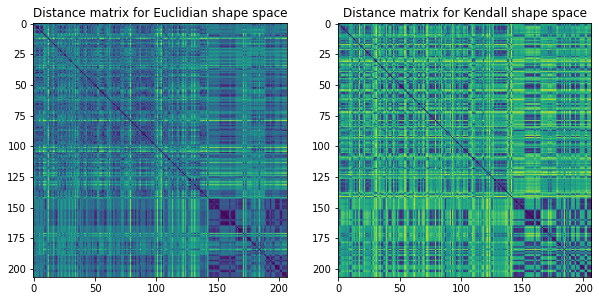

In [14]:
#Distance matrix 

m_ambient = 2
k_landmarks = 16

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric
pose_preshape = preshape.projection(dataset)
base_point = pose_preshape[0]
pose_shape = preshape.align(point=pose_preshape, base_point=base_point)
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)
dist_pairwise = kendall_metric.dist_pairwise(pose_shape)
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(121)

eucl_metric = EuclideanMetric(2 * 16)
nsamples, nx, ny = dataset.shape
posture = dataset.reshape((nsamples,nx*ny))
eucl_pair_dist = eucl_metric.dist_pairwise(posture)
ax.imshow(eucl_pair_dist);
plt.title("Distance matrix for Euclidian shape space")


ax = fig.add_subplot(122)
ax.imshow(dist_pairwise);
plt.title("Distance matrix for Kendall shape space")


In [15]:
# Verify that all points lie on the preshape space
posture_preshape = preshape.projection(dataset)
validate = (preshape.belongs(posture_preshape))
print("Check if points lie on the Kendall shape space : " + str(np.all(validate)))

Check if points lie on the Kendall shape space : True



### Classify the features using Logistic regression

Now, we perform logistic regression on the reduced dimensions.
For the manifold projected data, we perform logistic regression on the tangent space
We perform logistic regression on varying number of dimensions:

In [16]:
# 2 Principle Components
# PCA
euclidean_train = []
euclidean_test = []
kendall_train = []
kendall_test = []

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 2
for i in range(10):
    X_train_pca, y_train,train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

euclidean_train.append(np.mean(train_acc_avg))
euclidean_test.append(np.mean(test_acc_avg))

# Train PCA
train_acc_avg = list()
test_acc_avg = list()
n_components = 2
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, n_components)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
    


print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

kendall_train.append(np.mean(train_acc_avg))
kendall_test.append(np.mean(test_acc_avg))

Average Training accuracy (Eucidian metric): 0.8327200000000001
Average Test accuracy (Eucidian metric): 0.82857
Average Training accuracy (Kendall shape metric): 0.82728
Average Test accuracy (Kendall shape metric): 0.8285599999999999


In [17]:
# 5 Principle Components

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 5
for i in range(10):
    X_train_pca, y_train,train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

euclidean_train.append(np.mean(train_acc_avg))
euclidean_test.append(np.mean(test_acc_avg))

# Tangent PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

kendall_train.append(np.mean(train_acc_avg))
kendall_test.append(np.mean(test_acc_avg))

Average Training accuracy (Eucidian metric): 0.8424299999999999
Average Test accuracy (Eucidian metric): 0.8523799999999999
Average Training accuracy (Kendall shape metric): 0.8278700000000001
Average Test accuracy (Kendall shape metric): 0.8333200000000002


In [18]:
# 10 Principle Components

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 10
for i in range(10):
    X_train_pca, y_train,train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

euclidean_train.append(np.mean(train_acc_avg))
euclidean_test.append(np.mean(test_acc_avg))


#Tanget PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

kendall_train.append(np.mean(train_acc_avg))
kendall_test.append(np.mean(test_acc_avg))

Average Training accuracy (Eucidian metric): 0.8963600000000002
Average Test accuracy (Eucidian metric): 0.85476
Average Training accuracy (Kendall shape metric): 0.8254400000000001
Average Test accuracy (Kendall shape metric): 0.7928499999999999


In [19]:
# 20 Principle Components

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 20
for i in range(10):
    X_train_pca, y_train, train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

euclidean_train.append(np.mean(train_acc_avg))
euclidean_test.append(np.mean(test_acc_avg))

#Tangent PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

kendall_train.append(np.mean(train_acc_avg))
kendall_test.append(np.mean(test_acc_avg))

Average Training accuracy (Eucidian metric): 0.9460599999999999
Average Test accuracy (Eucidian metric): 0.8142699999999999
Average Training accuracy (Kendall shape metric): 0.8339400000000001
Average Test accuracy (Kendall shape metric): 0.81666


In [20]:
# 32 Components (All)
import warnings
warnings.filterwarnings("ignore")

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 32
for i in range(10):
    X_train_pca, y_train, train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

euclidean_train.append(np.mean(train_acc_avg))
euclidean_test.append(np.mean(test_acc_avg))

# Tangent PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

kendall_train.append(np.mean(train_acc_avg))
kendall_test.append(np.mean(test_acc_avg))

Average Training accuracy (Eucidian metric): 0.9939399999999999
Average Test accuracy (Eucidian metric): 0.8761800000000001
Average Training accuracy (Kendall shape metric): 0.84726
Average Test accuracy (Kendall shape metric): 0.8476100000000001


Now, let us plot the training and test accuracy vs the number of principle components

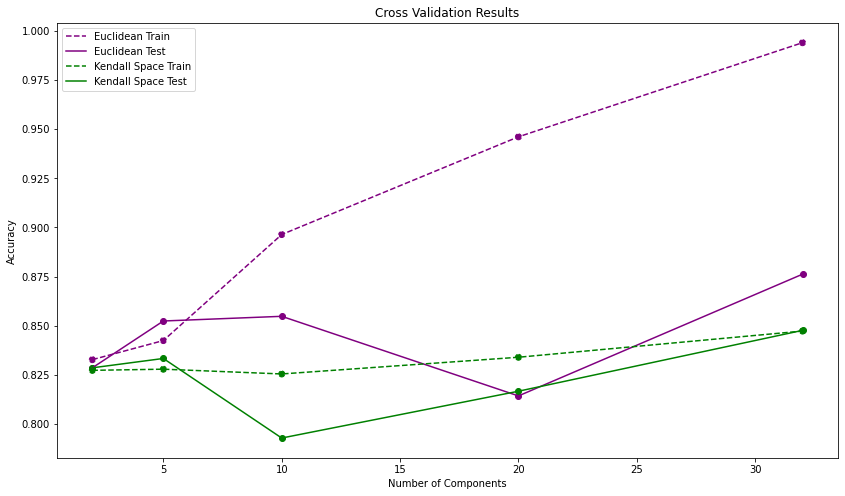

In [24]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 14, 8

n_comp = [2, 5, 10, 20, 32]
euclidean_train
euclidean_test
kendall_train
kendall_test

plt.scatter(n_comp, euclidean_train, color='purple', linestyle = '--')
plt.plot(n_comp, euclidean_train, label='Euclidean Train',color='purple', linestyle = '--')

plt.scatter(n_comp, euclidean_test, color='purple')
plt.plot(n_comp, euclidean_test,  label='Euclidean Test', color='purple')

plt.scatter(n_comp, kendall_train, color='green',linestyle = '--')
plt.plot(n_comp, kendall_train,  label='Kendall Space Train', color='green',linestyle = '--')

plt.scatter(n_comp, kendall_test, color='green')
plt.plot(n_comp, kendall_test,  label='Kendall Space Test', color='green')
    
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Cross Validation Results')
plt.legend()

plt.show()

# Conclusions
#### Observations
- For the case where we try to classify running and bicycling, we observed that Euclidian metric performed better over the Kendall shape space projections (The results for this can be obtained by commenting in the respective cell)
- For the classification of Standing vs Eating , we observe that for the Euclidian case, there is a large gap between the test and the train accuracy. 
- We suspect this is because the data is overfitted and will need some regularization in the loss function
- However for the Kendall shape metric, the training and test accuracy remain similar without any regularization


Thus, we can say that projecting the data on the Kendall shape space normalized the information and gives consistent training and test accuracy without the need of any hyperparameters

#### Limitations of the Dataset
- Keypoints are only 2D
- Keypoints may leave out key parts of the body, like individual facial features, fingers, and toes
- Not all data is full body and don't feature all 16 keypoints